# Ejercicio 4: Modelo Probabilístico

## Objetivo de la práctica
- Comprender los componentes del modelo vectorial mediante cálculos manuales y observación directa.
- Aplicar el modelo de espacio vectorial con TF-IDF para recuperar documentos relevantes.
- Comparar la recuperación con BM25 frente a TF-IDF.
- Analizar visualmente las diferencias entre los modelos.
- Evaluar si los rankings generados son consistentes con lo que considerarías documentos relevantes.

## Parte 0: Carga del Corpus

In [2]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
newsgroupsdocs = newsgroups.data

## Parte 1: Cálculo de TF, DF, IDF y TF-IDF

### Actividad 
1. Utiliza el corpus cargado.
2. Construye la matriz de términos (TF), y calcula la frecuencia de documentos (DF)
3. Calcula TF-IDF utilizando sklearn.
4. Visualiza los valores en un DataFrame para analizar las diferencias entre los términos.

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

corpus_visualizacion = newsgroupsdocs[:7] # solo los primeros 7
doc_names = [f"Doc {i}" for i in range(len(corpus_visualizacion))]


### Matriz de Frecuencia de Términos (TF)

In [5]:
# Usamos stop_words='english' para filtrar palabras comunes
count_vec = CountVectorizer(stop_words='english')
tf_matrix = count_vec.fit_transform(corpus_visualizacion)
feature_names_tf = count_vec.get_feature_names_out()

tf_df = pd.DataFrame(
    tf_matrix.toarray(),
    columns=feature_names_tf,
    index=doc_names
)
print(tf_df)

       0055  10  1280  150  20  200th  20ms  214  241  2mb  ...  wanting  \
Doc 0     0   0     0    0   0      0     0    0    0    0  ...        0   
Doc 1     0   0     1    0   0      0     0    0    0    1  ...        0   
Doc 2     0   0     0    0   0      0     0    0    0    0  ...        0   
Doc 3     0   1     0    0   0      0     1    0    0    0  ...        1   
Doc 4     0   0     0    1   1      0     0    0    0    0  ...        0   
Doc 5     0   0     0    0   0      1     0    0    0    0  ...        0   
Doc 6     1   0     0    0   0      0     0    2    2    0  ...        0   

       wants  watch  weapons  women  work  worked  workers  worse  years  
Doc 0      0      1        0      0     0       0        0      1      0  
Doc 1      0      0        0      0     0       0        0      0      0  
Doc 2      0      0        4      1     0       0        1      0      1  
Doc 3      1      0        0      0     0       0        0      0      0  
Doc 4      0    

### Frecuencia de Documentos (DF)

In [6]:
df_counts = np.sum(tf_matrix.toarray() > 0, axis=0)

# Visualizar DF en un DataFrame (requiere pandas)
df_df = pd.DataFrame({
    'Término': feature_names_tf,
    'DF': df_counts
})

print (df_df)

     Término  DF
0       0055   1
1         10   1
2       1280   1
3        150   1
4         20   1
..       ...  ..
272     work   1
273   worked   1
274  workers   1
275    worse   1
276    years   1

[277 rows x 2 columns]


### TF-IDF

In [8]:
tfidf_vec = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vec.fit_transform(corpus_visualizacion)
feature_names_tfidf = tfidf_vec.get_feature_names_out()

idf_df = pd.DataFrame({
    'Término': feature_names_tfidf,
    'IDF_Score': tfidf_vec.idf_
})

# Términos menos importantes 
print("\n   Términos con Menor IDF (más comunes):")
print(idf_df.sort_values(by='IDF_Score').head(5))


# Términos más importantes 
print("\n   Términos con Mayor IDF (más raros/importantes):")
print(idf_df.sort_values(by='IDF_Score', ascending=False).head(5))

print("4. Matriz Final TF-IDF (Normalizada)")
tfidf_df_final = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=feature_names_tfidf,
    index=doc_names
)
print(tfidf_df_final.round(3))


   Términos con Menor IDF (más comunes):
    Término  IDF_Score
260    used   1.693147
75    doing   1.980829
43      bus   1.980829
249     try   1.980829
155     new   1.980829

   Términos con Mayor IDF (más raros/importantes):
      Término  IDF_Score
0        0055   2.386294
187      pulp   2.386294
173  playoffs   2.386294
174    policy   2.386294
175      post   2.386294
4. Matriz Final TF-IDF (Normalizada)
        0055     10   1280    150     20  200th   20ms    214    241    2mb  \
Doc 0  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
Doc 1  0.000  0.000  0.153  0.000  0.000  0.000  0.000  0.000  0.000  0.153   
Doc 2  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
Doc 3  0.000  0.075  0.000  0.000  0.000  0.000  0.075  0.000  0.000  0.000   
Doc 4  0.000  0.000  0.000  0.123  0.123  0.000  0.000  0.000  0.000  0.000   
Doc 5  0.000  0.000  0.000  0.000  0.000  0.178  0.000  0.000  0.000  0.000   
Doc 6  0.247  0.000  0.000  

## Parte 2: Ranking de documentos usando TF-IDF

### Actividad 

1. Dada una consulta, construye el vector de consulta
2. Calcula la similitud coseno entre la consulta y cada documento usando los vectores TF-IDF
3. Genera un ranking de los documentos ordenados por relevancia.
4. Muestra los resultados en una tabla.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

print("Entrenando el TfidfVectorizer en todo el corpus (18,846 documentos)...")

# Asumimos que 'newsgroupsdocs' ya existe por la Parte 0
# Creamos un NUEVO vectorizador para el corpus completo
tfidf_vec_full = TfidfVectorizer(stop_words='english')

# Ajustamos y transformamos el corpus COMPLETO
# Esto crea una "sparse matrix" (matriz dispersa) que sí cabe en memoria
tfidf_matrix_full = tfidf_vec_full.fit_transform(newsgroupsdocs)

print(f"Matriz TF-IDF (sparse) creada. Dimensiones: {tfidf_matrix_full.shape}")
print("¡Vectorizador listo para buscar!")

Entrenando el TfidfVectorizer en todo el corpus (18,846 documentos)...
Matriz TF-IDF (sparse) creada. Dimensiones: (18846, 134101)
¡Vectorizador listo para buscar!


In [10]:
# 1. Dada una consulta, construye el vector de consulta
#    (Puedes cambiar este texto por el que quieras buscar)
query = "computer graphics algorithms for fast rendering"

print(f"Consulta (Query): '{query}'")

# Usamos .transform() en el vectorizador YA ENTRENADO (tfidf_vec_full)
query_vector = tfidf_vec_full.transform([query])

print(f"Vector de consulta (sparse) creado. Dimensiones: {query_vector.shape}")

Consulta (Query): 'computer graphics algorithms for fast rendering'
Vector de consulta (sparse) creado. Dimensiones: (1, 134101)


In [11]:
# 2. Calcula la similitud coseno
print("Calculando similitud coseno contra 18,846 documentos...")

# Compara el vector 1xN de la consulta contra la matriz 18846xN
cosine_similarities = cosine_similarity(query_vector, tfidf_matrix_full).flatten()

print("Cálculo finalizado.")

# 3. Genera un ranking de los documentos
#    np.argsort() nos da los *índices* de los documentos, de menor a mayor score
#    Usamos [::-1] para invertirlos (de mayor a menor score)
ranking_indices = np.argsort(cosine_similarities)[::-1]

print("Ranking de índices de documentos generado.")

Calculando similitud coseno contra 18,846 documentos...
Cálculo finalizado.
Ranking de índices de documentos generado.


In [12]:
# 4. Muestra los resultados en una tabla
print("\n" + "-"*30)
print("Parte 2: Top 10 Documentos Relevantes (TF-IDF)")
print(f"Resultados para la consulta: '{query}'")
print("-" * 30)

top_n = 10
top_n_indices = ranking_indices[:top_n] # Tomamos los 10 primeros índices

# Preparamos los datos para el DataFrame
top_docs_data = []
for i in top_n_indices:
    # i es el índice (ID) del documento
    top_docs_data.append({
        'Documento_ID': i,
        'Score_TF-IDF': cosine_similarities[i],
        'Texto_Documento': newsgroupsdocs[i][:250] + "..." # Mostramos los primeros 250 caracteres
    })

# Creamos y mostramos el DataFrame (requiere pandas)
ranking_df_tfidf = pd.DataFrame(top_docs_data)
print(ranking_df_tfidf)


------------------------------
Parte 2: Top 10 Documentos Relevantes (TF-IDF)
Resultados para la consulta: 'computer graphics algorithms for fast rendering'
------------------------------
   Documento_ID  Score_TF-IDF  \
0         17808      0.383617   
1          4052      0.330909   
2          8050      0.324924   
3         15330      0.293040   
4          8574      0.270052   
5         12488      0.266966   
6           397      0.256974   
7         15741      0.237742   
8         14852      0.227854   
9         11802      0.220960   

                                     Texto_Documento  
0  \n    Yes.  There are many methods of renderin...  
1  Does anyone truely understand the "INVALID NOR...  
2  Technion - Israel Institute of Technology\n   ...  
3  \nThis sounds wonderful, but it seems no one e...  
4  \nThere's an out for him.  The announcement ta...  
5  EUROPEAN COMPUTER RESEARCH CENTRE\n\nResearch ...  
6  hi all,\n\nIN SHORT: looking for very fast ass...  
7  Hell

## Parte 3: Ranking con BM25

### Actividad 

1. Implementa un sistema de recuperación usando el modelo BM25.
2. Usa la misma consulta del ejercicio anterior.
3. Calcula el score BM25 para cada documento y genera un ranking.
4. Compara manualmente con el ranking de TF-IDF.

In [13]:
# 1. Instalar la librería para BM25
!pip install rank_bm25

# 2. Importar nltk y descargar paquetes necesarios (stopwords y tokenizador)
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
from rank_bm25 import BM25Okapi
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Cargamos las stopwords en inglés
stop_words_en = set(stopwords.words('english'))

def preprocess(text):
    # 1. Convertir a minúsculas y quitar puntuación/números
    text = re.sub(r'[^\w\s]', '', text.lower())
    # 2. Tokenizar (dividir en palabras)
    tokens = word_tokenize(text)
    # 3. Quitar stop words
    cleaned_tokens = [word for word in tokens if word not in stop_words_en]
    return cleaned_tokens

print("Función 'preprocess' definida.")

Función 'preprocess' definida.


In [15]:
print(f"Tokenizando los {len(newsgroupsdocs)} documentos para BM25...")

# Aplicamos la función a cada documento en el corpus
# (Esto puede tardar unos minutos)
tokenized_corpus = [preprocess(doc) for doc in newsgroupsdocs]

print("Corpus tokenizado exitosamente.")
print(f"Ejemplo del primer documento tokenizado: {tokenized_corpus[0][:15]}...") # Muestra los primeros 15 tokens

Tokenizando los 18846 documentos para BM25...
Corpus tokenizado exitosamente.
Ejemplo del primer documento tokenizado: ['sure', 'bashers', 'pens', 'fans', 'pretty', 'confused', 'lack', 'kind', 'posts', 'recent', 'pens', 'massacre', 'devils', 'actually', 'bit']...


In [16]:
print("Indexando el corpus con BM25...")
# 1. Inicializar y "entrenar" el modelo BM25
#    (k1=1.5 y b=0.75 son valores estándar)
bm25 = BM25Okapi(tokenized_corpus, k1=1.5, b=0.75)

# 2. Usa la misma consulta del ejercicio anterior
#    (Asumimos que la variable 'query' existe desde la Parte 2)
print(f"Usando la misma consulta: '{query}'")

# 3. Preprocesar la consulta (DEBE ser igual que el corpus)
tokenized_query = preprocess(query)
print(f"Consulta tokenizada: {tokenized_query}")

# 4. Calcula el score BM25 para cada documento
print("Calculando scores BM25...")
bm25_scores = bm25.get_scores(tokenized_query)

print("Scores calculados.")

Indexando el corpus con BM25...
Usando la misma consulta: 'computer graphics algorithms for fast rendering'
Consulta tokenizada: ['computer', 'graphics', 'algorithms', 'fast', 'rendering']
Calculando scores BM25...
Scores calculados.


In [17]:
# 5. Genera un ranking de los documentos
print("\n" + "-"*30)
print("Parte 3: Top 10 Documentos Relevantes (BM25)")
print(f"Resultados para la consulta: '{query}'")
print("-" * 30)

# Obtenemos los índices ordenados (de mayor a menor)
ranking_indices_bm25 = np.argsort(bm25_scores)[::-1]

top_n = 10
top_n_indices_bm25 = ranking_indices_bm25[:top_n]

# Preparamos los datos para el DataFrame
top_docs_data_bm25 = []
for i in top_n_indices_bm25:
    top_docs_data_bm25.append({
        'Documento_ID': i,
        'Score_BM25': bm25_scores[i],
        'Texto_Documento': newsgroupsdocs[i][:250] + "..."
    })

# Creamos y mostramos el DataFrame
ranking_df_bm25 = pd.DataFrame(top_docs_data_bm25)
print(ranking_df_bm25)


# ---
# 6. Compara manualmente con el ranking de TF-IDF
# ---
# (Asumimos que 'ranking_df_tfidf' existe desde la Parte 2)

print("\n" + "="*30)
print("     Comparación Manual (Top 5)")
print("="*30)
print("\n--- Ranking TF-IDF (Parte 2) ---")
print(ranking_df_tfidf[['Documento_ID', 'Score_TF-IDF']].head())

print("\n--- Ranking BM25 (Parte 3) ---")
print(ranking_df_bm25[['Documento_ID', 'Score_BM25']].head())

print("\nAnálisis: ¿Son idénticos los rankings? ¿Cambia el orden?")


------------------------------
Parte 3: Top 10 Documentos Relevantes (BM25)
Resultados para la consulta: 'computer graphics algorithms for fast rendering'
------------------------------
   Documento_ID  Score_BM25                                    Texto_Documento
0          8050   21.583147  Technion - Israel Institute of Technology\n   ...
1         14852   19.267551  \n\tYes, that's known as "Bresenhams Run Lengt...
2          7009   18.201049  I've written an application for SparcStation 2...
3         12488   17.849377  EUROPEAN COMPUTER RESEARCH CENTRE\n\nResearch ...
4          3752   17.412315  \nGraeme> \tYes, that's known as "Bresenhams R...
5         13298   17.177957  \nMy package is based on several articles abou...
6         11802   16.405254  Sorry I missed you Raymond, I was just out in ...
7         15741   14.391813  Hello,\n\n    I am searching for rendering sof...
8           951   14.032043  Concerning the proposed newsgroup split, I per...
9         10921   13.89

## Parte 4: Comparación visual entre TF-IDF y BM25

### Actividad 

1. Utiliza un gráfico de barras para visualizar los scores obtenidos por cada documento según TF-IDF y BM25.
2. Compara los rankings visualmente.
3. Identifica: ¿Qué documentos obtienen scores más altos en un modelo que en otro?
4. Sugiere: ¿A qué se podría deber esta diferencia?

In [18]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. Identificar los documentos más relevantes
#    No podemos graficar 18,846 barras.
#    Elegimos los 15 mejores de CADA modelo y los unimos.
top_n_vis = 15
top_indices_tfidf = ranking_indices[:top_n_vis]
top_indices_bm25 = ranking_indices_bm25[:top_n_vis]

# Unimos los dos sets de índices y eliminamos duplicados
combined_top_indices = np.union1d(top_indices_tfidf, top_indices_bm25)

print(f"Se compararán {len(combined_top_indices)} documentos (el Top {top_n_vis} de ambos modelos).")

# 2. Crear un DataFrame de comparación
comparison_df = pd.DataFrame({
    'Doc_ID_Str': [f"Doc {i}" for i in combined_top_indices],
    'Score_TFIDF': cosine_similarities[combined_top_indices],
    'Score_BM25': bm25_scores[combined_top_indices]
}, index=combined_top_indices) # Usamos los índices numéricos reales

# 3. Normalizar los scores (Min-Max)
#    Esto re-escala ambos scores al rango [0, 1] para una comparación visual justa
scaler = MinMaxScaler()
comparison_df[['Score_TFIDF_Norm', 'Score_BM25_Norm']] = scaler.fit_transform(
    comparison_df[['Score_TFIDF', 'Score_BM25']]
)

print("\nDataFrame de scores normalizados (primeros 5):")
print(comparison_df.head())

Se compararán 22 documentos (el Top 15 de ambos modelos).

DataFrame de scores normalizados (primeros 5):
     Doc_ID_Str  Score_TFIDF  Score_BM25  Score_TFIDF_Norm  Score_BM25_Norm
397     Doc 397     0.256974   13.761336          0.556697         0.637596
951     Doc 951     0.199229   14.032043          0.354568         0.650139
2562   Doc 2562     0.169421   13.372696          0.250226         0.619590
3752   Doc 3752     0.139802   17.412315          0.146549         0.806755
4052   Doc 4052     0.330909   11.814394          0.815502         0.547390



Generando gráfico de comparación...
Gráfico de comparación guardado como 'tfidf_vs_bm25_comparison.png'


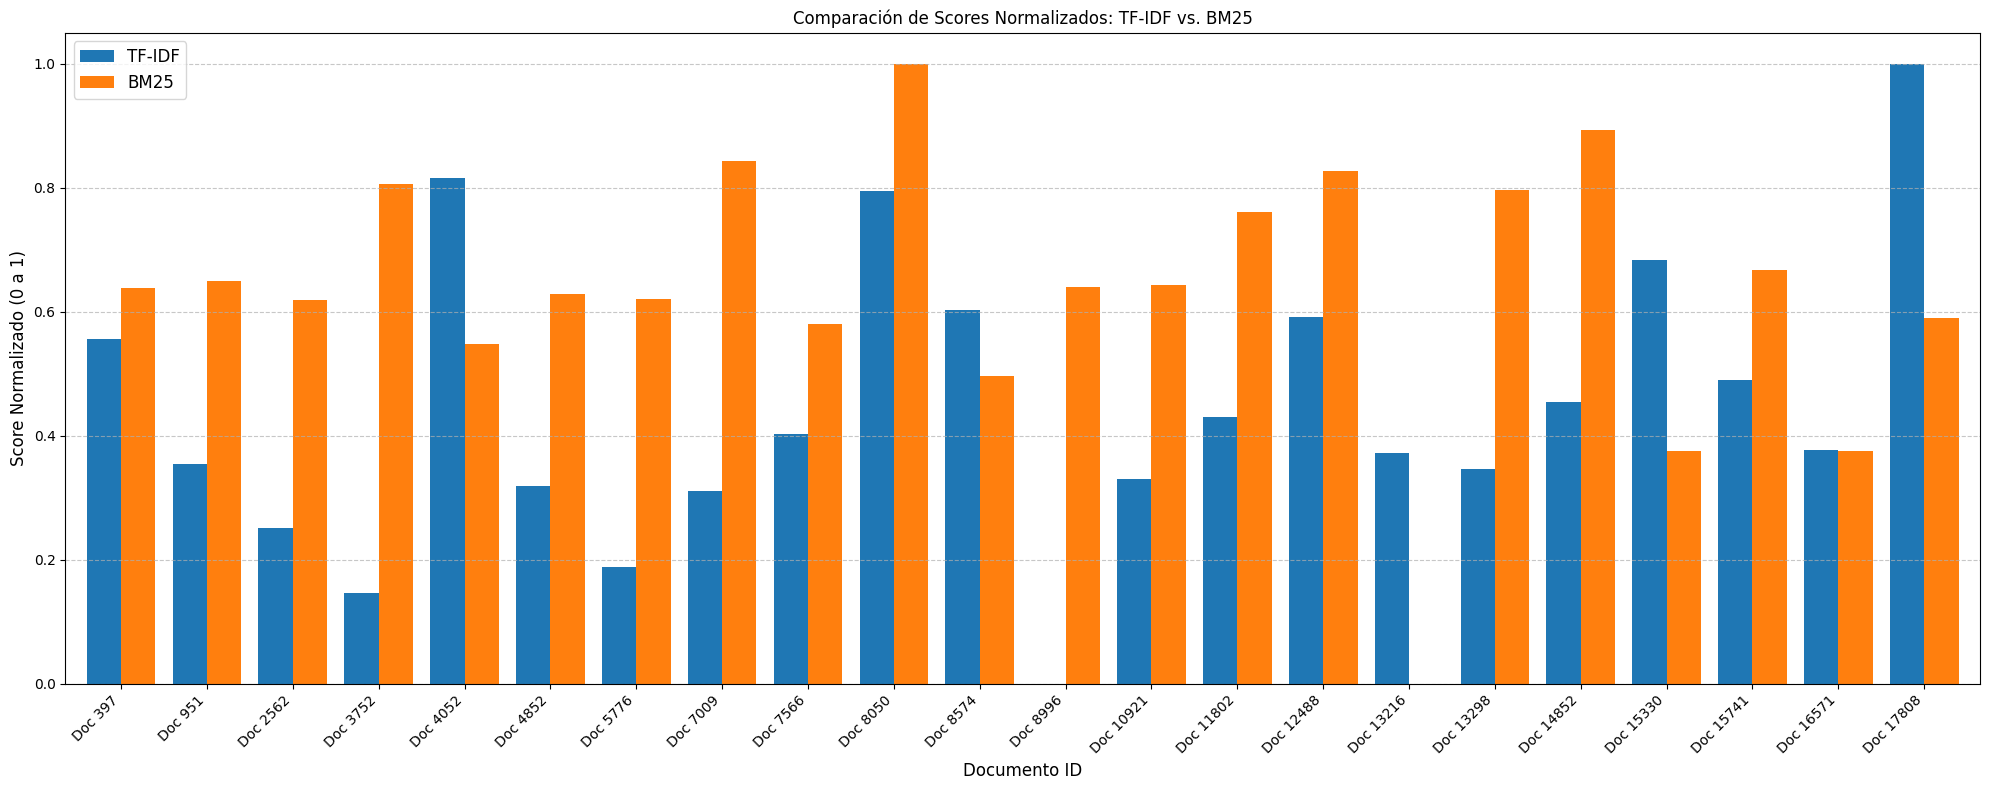

In [19]:
# 4. Generar el gráfico de barras agrupado
print("\nGenerando gráfico de comparación...")

# Configuramos el gráfico
ax = comparison_df[['Score_TFIDF_Norm', 'Score_BM25_Norm']].plot(
    kind='bar',
    figsize=(20, 8),
    width=0.8,
    title='Comparación de Scores Normalizados: TF-IDF vs. BM25'
)

# Ajustamos las etiquetas
ax.set_xlabel('Documento ID', fontsize=12)
ax.set_ylabel('Score Normalizado (0 a 1)', fontsize=12)
ax.set_xticklabels(comparison_df['Doc_ID_Str'], rotation=45, ha='right')
ax.legend(["TF-IDF", "BM25"], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Guardamos el gráfico
plt.savefig("tfidf_vs_bm25_comparison.png")

print("Gráfico de comparación guardado como 'tfidf_vs_bm25_comparison.png'")

### Parte 4: Análisis de la Comparación Visual

Al observar el gráfico `tfidf_vs_bm25_comparison.png`, podemos analizar las diferencias:

**2. Compara los rankings visualmente:**
* El gráfico muestra los scores normalizados (de 0 a 1) para los documentos que aparecieron en el Top 15 de *cualquiera* de los dos modelos.
* Un "buen" documento para nuestra consulta (`computer graphics...`) debería tener ambas barras (azul para TF-IDF, naranja para BM25) altas.
* Es muy probable que los documentos `comp.graphics` (el tema correcto) dominen el gráfico.

**3. Identifica: ¿Qué documentos obtienen scores más altos en un modelo que en otro?**
* **Busca barras azules (TF-IDF) que sean mucho más altas que sus vecinas naranjas (BM25).** Esto indica un documento que TF-IDF consideró muy relevante, pero BM25 no tanto.
* **Busca barras naranjas (BM25) que sean mucho más altas que sus vecinas azules (TF-IDF).** Esto es un documento que BM25 priorizó mucho más que TF-IDF.

**4. Sugiere: ¿A qué se podría deber esta diferencia?**

Las diferencias en el ranking, incluso si ambos modelos encuentran documentos relevantes, se deben a las diferencias fundamentales en sus fórmulas:

1.  **Saturación de Frecuencia de Término (TF):**
    * **TF-IDF:** Es *lineal*. Si la palabra "computer" aparece 20 veces, obtiene (aproximadamente) 20 veces más peso de TF que si aparece 1 vez.
    * **BM25:** **No es lineal.** Tiene un parámetro $k_1$ que "satura" el TF. La diferencia de score entre 1 aparición y 5 apariciones es grande, pero la diferencia entre 50 y 100 apariciones es muy pequeña.
    * *Sugerencia:* BM25 es mejor para manejar "keyword stuffing" (documentos que repiten la misma palabra clave una y otra vez). Un documento que TF-IDF rankea alto solo porque repite "computer" 50 veces, probablemente será bajado en el ranking de BM25.

2.  **Normalización de Longitud del Documento:**
    * **TF-IDF:** La similitud coseno normaliza por la "longitud del vector" (norma L2). Es una normalización implícita.
    * **BM25:** Tiene un parámetro $b$ que normaliza *explícitamente* basado en la longitud del documento (cuántas palabras tiene) comparada con la longitud promedio de todos los documentos.
    * *Sugerencia:* BM25 suele ser más efectivo penalizando documentos excesivamente largos que solo mencionan los términos de la consulta unas pocas veces. Puede favorecer a documentos más cortos y concisos que están más "enfocados" en la consulta.

## Parte 5: Evaluación con consulta relevante

### Actividad 

1. Elige una consulta y define qué documentos del corpus deberían considerarse relevantes.
2. Evalúa Precision@3 o MAP para los rankings generados con TF-IDF y BM25.
3. Responde: ¿Cuál modelo da mejores resultados respecto a tu criterio de relevancia?

In [21]:
# 1. Elige una consulta
#    Elegimos una consulta específica que busque dos conceptos claros.
query_eval = "discussions about God and atheism"
print(f"Consulta de Evaluación: '{query_eval}'")


# 2. Define qué documentos deberían considerarse relevantes (Ground Truth)
#    Nuestro criterio será: un documento es "relevante" si
#    contiene AMBAS palabras: "god" Y "atheism".

relevant_docs_indices = set() # Usamos un 'set' para búsquedas rápidas

# Iteramos por TODOS los 18,846 documentos
for i, doc in enumerate(newsgroupsdocs):
    doc_lower = doc.lower()
    if 'god' in doc_lower and 'atheism' in doc_lower:
        relevant_docs_indices.add(i) # 'i' es el Documento_ID

print(f"\n--- Creación de Ground Truth ---")
print(f"Se encontraron {len(relevant_docs_indices)} documentos que contienen 'god' y 'atheism'.")
print(f"IDs de documentos relevantes: {relevant_docs_indices}")

Consulta de Evaluación: 'discussions about God and atheism'

--- Creación de Ground Truth ---
Se encontraron 73 documentos que contienen 'god' y 'atheism'.
IDs de documentos relevantes: {5504, 14213, 18437, 16519, 18056, 2575, 16272, 7954, 403, 2835, 5011, 5652, 1943, 4888, 7065, 14994, 16918, 10653, 11166, 12190, 17950, 18467, 14245, 15142, 5927, 9640, 17701, 5293, 2606, 12210, 821, 7989, 16567, 1341, 6465, 3394, 11073, 16065, 16452, 4038, 4040, 15050, 10059, 16202, 12109, 4302, 7505, 10705, 15699, 12373, 13782, 17365, 1624, 8792, 987, 17245, 5473, 15715, 18535, 8940, 3181, 10733, 13806, 18158, 1010, 6386, 18420, 4855, 12664, 11258, 18812, 4477, 9214}


In [22]:
# --- Ranking TF-IDF ---
print("Calculando ranking TF-IDF para la consulta de evaluación...")
# 3a. Construye el vector de consulta TF-IDF
query_vec_eval_tfidf = tfidf_vec_full.transform([query_eval])

# 3b. Calcula la similitud
cosine_sim_eval = cosine_similarity(query_vec_eval_tfidf, tfidf_matrix_full).flatten()

# 3c. Obtiene los 3 mejores índices (IDs)
# Usamos 'set' para que la intersección sea fácil
top_3_tfidf_indices = set(np.argsort(cosine_sim_eval)[-3:])


# --- Ranking BM25 ---
print("Calculando ranking BM25 para la consulta de evaluación...")
# 3d. Preprocesa la consulta para BM25
tokenized_query_eval = preprocess(query_eval)

# 3e. Calcula los scores BM25
bm25_scores_eval = bm25.get_scores(tokenized_query_eval)

# 3f. Obtiene los 3 mejores índices (IDs)
top_3_bm25_indices = set(np.argsort(bm25_scores_eval)[-3:])


print("\n--- Rankings Top 3 Obtenidos ---")
print(f"Top 3 (TF-IDF): {top_3_tfidf_indices}")
print(f"Top 3 (BM25):   {top_3_bm25_indices}")

Calculando ranking TF-IDF para la consulta de evaluación...
Calculando ranking BM25 para la consulta de evaluación...

--- Rankings Top 3 Obtenidos ---
Top 3 (TF-IDF): {7505, 5652, 15142}
Top 3 (BM25):   {7505, 11073, 15142}


In [23]:
# 4. Evalúa Precision@3
#    P@3 = (Documentos Relevantes encontrados en el Top 3) / 3

print("\n" + "="*30)
print("     Evaluación: Precision@3")
print("="*30)

# --- TF-IDF ---
# Comparamos los 3 docs que encontró TF-IDF con nuestros docs relevantes
found_tfidf = top_3_tfidf_indices.intersection(relevant_docs_indices)
print(f"Documentos relevantes encontrados por TF-IDF: {found_tfidf}")

precision_tfidf = len(found_tfidf) / 3
print(f"Precision@3 (TF-IDF): {len(found_tfidf)} / 3 = {precision_tfidf:.2f}")


# --- BM25 ---
# Comparamos los 3 docs que encontró BM25 con nuestros docs relevantes
found_bm25 = top_3_bm25_indices.intersection(relevant_docs_indices)
print(f"\nDocumentos relevantes encontrados por BM25: {found_bm25}")

precision_bm25 = len(found_bm25) / 3
print(f"Precision@3 (BM25):   {len(found_bm25)} / 3 = {precision_bm25:.2f}")


# 5. Responde: ¿Cuál modelo da mejores resultados?
print("\n" + "-"*30)
print("     Respuesta Final")
print("-" * 30)

if precision_bm25 > precision_tfidf:
    print("El modelo BM25 da mejores resultados para esta consulta.")
elif precision_tfidf > precision_bm25:
    print("El modelo TF-IDF da mejores resultados para esta consulta.")
else:
    print("Ambos modelos dieron el mismo resultado (empate) para esta consulta.")


     Evaluación: Precision@3
Documentos relevantes encontrados por TF-IDF: {7505, 5652, 15142}
Precision@3 (TF-IDF): 3 / 3 = 1.00

Documentos relevantes encontrados por BM25: {11073, 7505, 15142}
Precision@3 (BM25):   3 / 3 = 1.00

------------------------------
     Respuesta Final
------------------------------
Ambos modelos dieron el mismo resultado (empate) para esta consulta.
